### Import the necessary libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score

#for tuning the model
from sklearn.model_selection import GridSearchCV



#to ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:.2f}'.format)

### Read the dataset

In [134]:
#reading the dataset
df = pd.read_csv('churns.csv')

In [135]:
#creating billing_month_year
df['billing_month_year'] = df['billing_month'].astype(str) + '-' + df['billing_year'].astype(str)

#droping the specified columns
columns_to_drop = ['user_id','country','intended_use','user_defined_role','avg_download_interval_hours','avg_survey_response_rating','renewal_count','has_sfx_downloads', 'has_template_downloads','has_multiple_content_classes', 'created_content_folder', 'billing_month_year', 'billing_month', 'billing_year', 'survey_completed_count','content_folder_count']
df.drop(columns=columns_to_drop, inplace=True)

#get rid of Organic Social
df.drop(df[df['subchannel'] == 'Organic Social'].index, inplace=True)

#turning churn into a categorical variable
df['churn'].replace({1: 'Yes', 0: 'No'}, inplace=True)

In [136]:
df['subchannel'].value_counts()

subchannel
Brand         682186
SEM            91607
SEO            65379
Influencer     39619
Affiliate       8938
Social          7325
Podcast         1540
Name: count, dtype: int64

### Printing the information

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896594 entries, 0 to 896594
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   channel                      896594 non-null  object 
 1   subchannel                   896594 non-null  object 
 2   plan                         896594 non-null  object 
 3   billing_interval             896594 non-null  object 
 4   days_active                  896594 non-null  int64  
 5   auto_cancellation_count      896594 non-null  int64  
 6   download_abuse_count         896594 non-null  int64  
 7   login_abuse_count            896594 non-null  int64  
 8   session_sharing_abuse_count  896594 non-null  int64  
 9   avg_monthly_downloads        896594 non-null  float64
 10  video_download_count         896594 non-null  int64  
 11  image_download_count         896594 non-null  int64  
 12  audio_download_count         896594 non-null  int64  
 13  temp

In [138]:
#Creating numerical columns
num_cols=['days_active','auto_cancellation_count','download_abuse_count','login_abuse_count'
          ,'session_sharing_abuse_count' ,'avg_monthly_downloads', 'video_download_count','image_download_count','audio_download_count', 'template_download_count', 'sfx_download_count','failed_transaction_count']

#Creating categorical variables 
cat_cols= ['churn','channel', 'subchannel', 'plan', 'billing_interval','payment_method', 'currency']

In [139]:
#checking summary statistics
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
days_active,896594.00,1067.81,1182.66,-1844.00,89.00,511.00,1855.00,14312.00
auto_cancellation_count,896594.00,0.13,0.42,0.00,0.00,0.00,0.00,38.00
download_abuse_count,896594.00,0.03,2.56,0.00,0.00,0.00,0.00,1719.00
login_abuse_count,896594.00,0.01,0.38,0.00,0.00,0.00,0.00,99.00
session_sharing_abuse_count,896594.00,0.00,0.01,0.00,0.00,0.00,0.00,2.00
avg_monthly_downloads,896594.00,46.66,415.40,1.00,3.67,11.50,29.46,117545.58
video_download_count,896594.00,275.53,3473.00,0.00,0.00,6.00,76.00,1348599.00
image_download_count,896594.00,60.53,839.14,0.00,0.00,0.00,4.00,355394.00
audio_download_count,896594.00,68.84,1067.02,0.00,0.00,0.00,6.00,663550.00
template_download_count,896594.00,17.56,141.71,0.00,0.00,0.00,3.00,41784.00


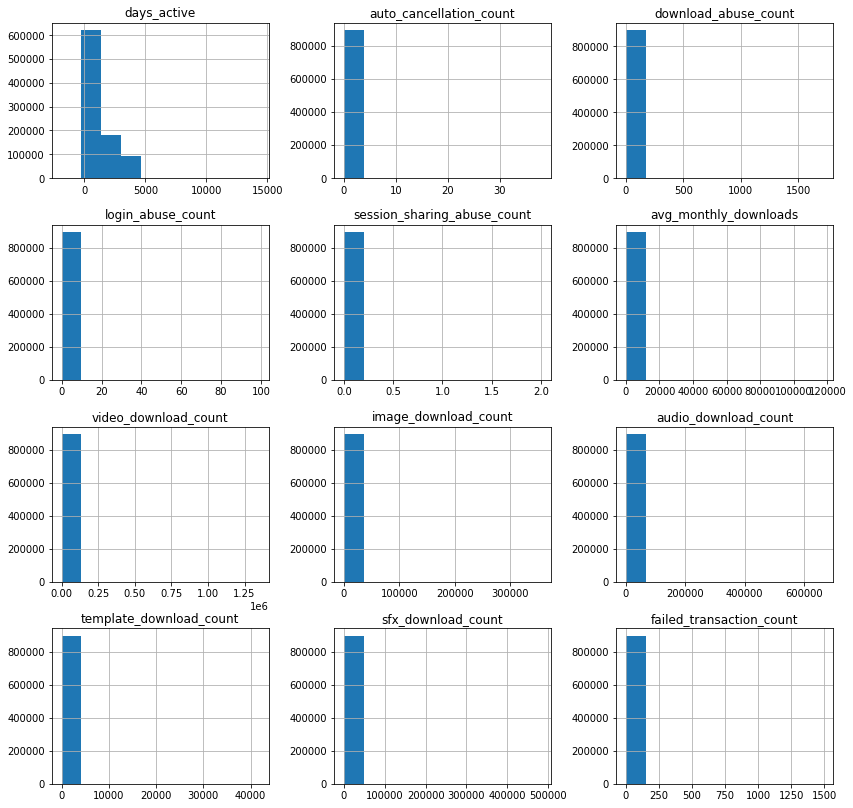

In [140]:
#creating histograms
df[num_cols].hist(figsize=(14,14))
plt.show()

In [141]:
#Printing the % sub categories of each category
for i in cat_cols:
    print(df[i].value_counts(normalize=True))
    print('*'*40)

churn
Yes   0.60
No    0.40
Name: proportion, dtype: float64
****************************************
channel
Unpaid        0.83
Bidded        0.11
Partnership   0.06
Name: proportion, dtype: float64
****************************************
subchannel
Brand        0.76
SEM          0.10
SEO          0.07
Influencer   0.04
Affiliate    0.01
Social       0.01
Podcast      0.00
Name: proportion, dtype: float64
****************************************
plan
Legacy       0.59
Unlimited    0.15
ULAA         0.14
Basic        0.08
Starter      0.03
Pro          0.00
Enterprise   0.00
Essentials   0.00
Business     0.00
Name: proportion, dtype: float64
****************************************
billing_interval
Monthly       0.55
Annual        0.42
Semi-Annual   0.03
Other         0.00
Name: proportion, dtype: float64
****************************************
payment_method
credit card   0.93
paypal        0.07
check         0.00
wire          0.00
Name: proportion, dtype: float64
****************

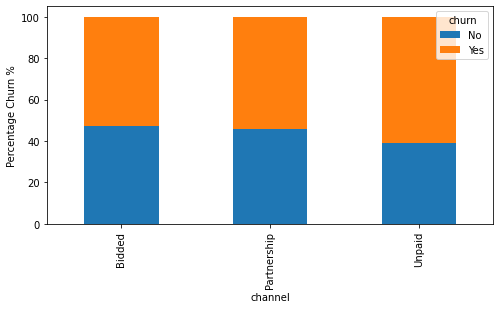

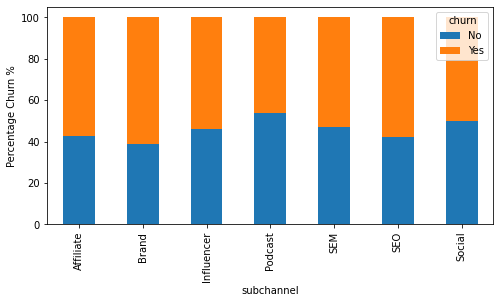

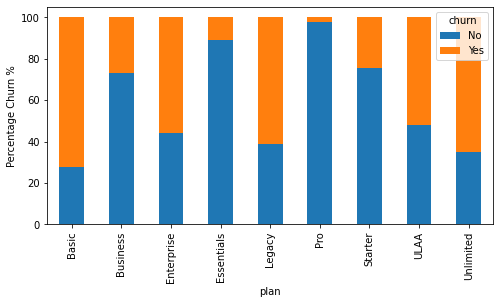

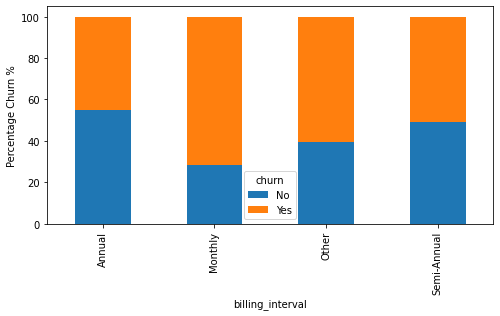

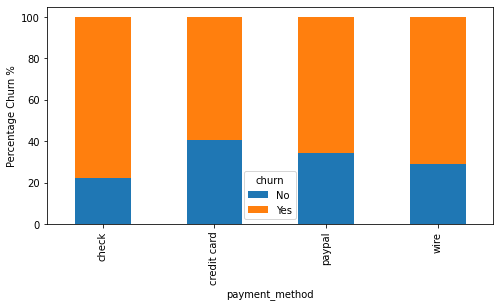

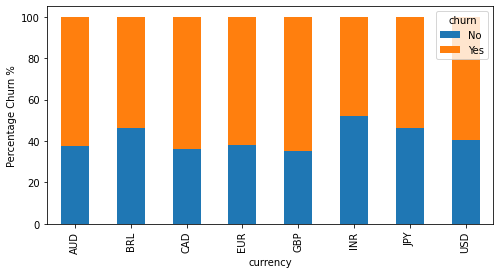

In [142]:
for i in cat_cols:
    if i!='churn':
        (pd.crosstab(df[i],df['churn'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Churn %')

In [143]:
#mean of numerical variables grouped by churn
df.groupby(['churn'])[num_cols].mean()

,days_active,auto_cancellation_count,download_abuse_count,login_abuse_count,session_sharing_abuse_count,avg_monthly_downloads,video_download_count,image_download_count,audio_download_count,template_download_count,sfx_download_count,failed_transaction_count
churn,,,,,,,,,,,,
No,2038.10,0.04,0.01,0.01,0.00,42.48,421.63,65.25,89.21,23.37,32.19,5.08
Yes,414.47,0.19,0.04,0.01,0.00,49.48,177.15,57.36,55.12,13.64,19.26,1.08


<Axes: >

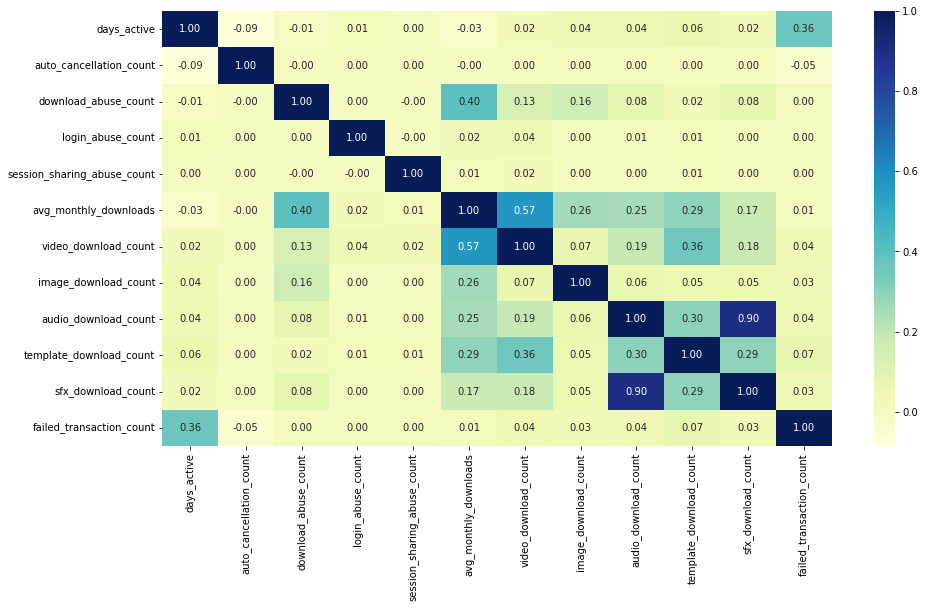

In [144]:
#plotting the correlation between numerical variables
plt.figure(figsize=(15,8))
sns.heatmap(df[num_cols].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

###  Preparing data for modeling

**Creating dummy variables for categorical Variables**

In [145]:
#creating list of dummy columns
to_get_dummies_for = ['channel', 'subchannel', 'plan', 'billing_interval','payment_method', 'currency']

#creating dummy variables
df = pd.get_dummies(data = df, columns= to_get_dummies_for, drop_first= True)      

#mapping overtime and attrition
dict_churn = {'Yes': 1, 'No': 0}

df['churn'] = df.churn.map(dict_churn)

**Separating the independent variables (X) and the dependent variable (Y)**

In [146]:
#Separating target variable and other variables
Y= df.churn
X= df.drop(columns = ['churn'])

In [147]:
#Scaling the data
sc=StandardScaler()
X_scaled=sc.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)

In [148]:
#splitting the data
x_train,x_test,y_train,y_test=train_test_split(X_scaled,Y,test_size=0.3,random_state=1,stratify=Y)

### Model evaluation criterion

#### The model can make two types of wrong predictions:
1. Predicting a customer will churn and they do not churn
2. Predicting a customer will not churn and they actually churn

#### Which case is more important? 
* **Predicting a customer will not churn and they actually churn** i.e. losing customers have a substantial impact on revenue, false negatives become more important as they represent missed opportunities to retain valuable customers.

#### How to reduce this loss i.e the need to reduce False Negatives?
* **We want to maximize Recall**,the higher the Recall the higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall (minimizing the false negatives) or in other words identifying the true positives (i.e. Class 1) very well, so that the company can provide incentives to control churn rate.

In [149]:
#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression Model 

In [150]:
#fitting logistic regression model
lg=LogisticRegression()
lg.fit(x_train,y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.89      0.91      0.90    252550
           1       0.94      0.92      0.93    375065

    accuracy                           0.92    627615
   macro avg       0.91      0.92      0.91    627615
weighted avg       0.92      0.92      0.92    627615



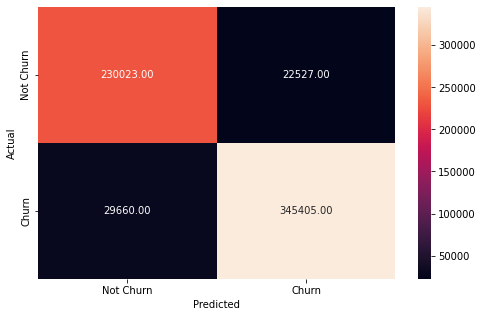

In [151]:
#checking the performance on the training data
y_pred_train = lg.predict(x_train)
metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90    108236
           1       0.94      0.92      0.93    160743

    accuracy                           0.92    268979
   macro avg       0.91      0.92      0.91    268979
weighted avg       0.92      0.92      0.92    268979



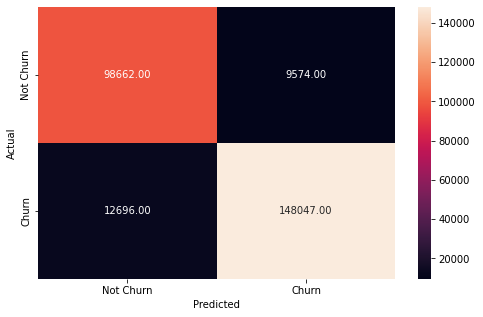

In [152]:
#checking the performance on the test dataset
y_pred_test = lg.predict(x_test)
metrics_score(y_test, y_pred_test)

In [153]:
#printing the coefficients of logistic regression
cols=X.columns

coef_lg=lg.coef_

pd.DataFrame(coef_lg,columns=cols).T.sort_values(by=0,ascending=False)

,0
plan_Legacy,2.27
auto_cancellation_count,0.51
billing_interval_Monthly,0.36
billing_interval_Semi-Annual,0.32
subchannel_Brand,0.31
audio_download_count,0.24
channel_Unpaid,0.19
image_download_count,0.19
template_download_count,0.13
plan_Enterprise,0.11


In [154]:
odds = np.exp(lg.coef_[0]) #finding the odds

# Create a DataFrame for the odds and include the feature names as a separate column
odds_df = pd.DataFrame({'odds': odds, 'feature': x_train.columns})

# Sort the DataFrame by the 'odds' column in descending order
odds_df_sorted = odds_df.sort_values(by='odds', ascending=False)

# Set 'feature' as the index and move it to the first column
odds_df_sorted = odds_df_sorted.set_index('feature').reset_index()


odds_df_sorted['probability'] = odds_df_sorted['odds']/(1 + odds_df_sorted['odds'])

odds_df_sorted

,feature,odds,probability
0,plan_Legacy,9.65,0.91
1,auto_cancellation_count,1.66,0.62
2,billing_interval_Monthly,1.43,0.59
3,billing_interval_Semi-Annual,1.38,0.58
4,subchannel_Brand,1.37,0.58
5,audio_download_count,1.28,0.56
6,channel_Unpaid,1.21,0.55
7,image_download_count,1.20,0.55
8,template_download_count,1.14,0.53
9,plan_Enterprise,1.12,0.53


In [156]:
odds_df_sorted.to_csv('churn_odds.csv', index=False)

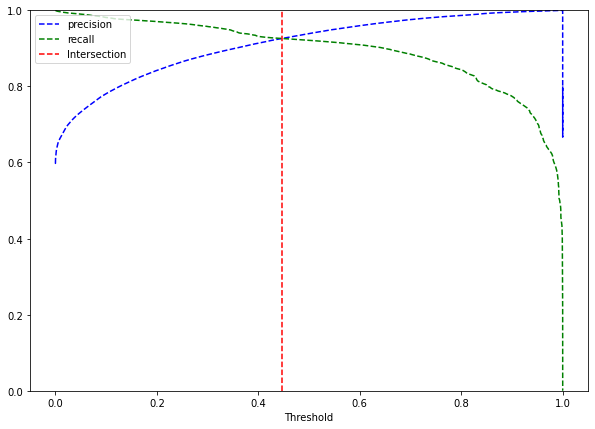

In [157]:
y_scores_lg = lg.predict_proba(x_train)# predict_proba gives the probability of each observation belonging to each class

precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:, 1])

# Find the threshold where recall and precision intersect
intersection_threshold = thresholds_lg[np.argmax(recalls_lg[:-1] == precisions_lg[:-1])]

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10, 7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label='recall')
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label='Intersection')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.show()

In [158]:
y_scores_lg = lg.predict_proba(x_train)[:, 1]  # Predicted probabilities of the positive class

# Assuming you have the true labels of the training set 'y_train'
# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_train, y_scores_lg)

print("ROC-AUC score:", roc_auc)

ROC-AUC score: 0.9727235231816731


              precision    recall  f1-score   support

           0       0.89      0.89      0.89    252550
           1       0.93      0.93      0.93    375065

    accuracy                           0.91    627615
   macro avg       0.91      0.91      0.91    627615
weighted avg       0.91      0.91      0.91    627615



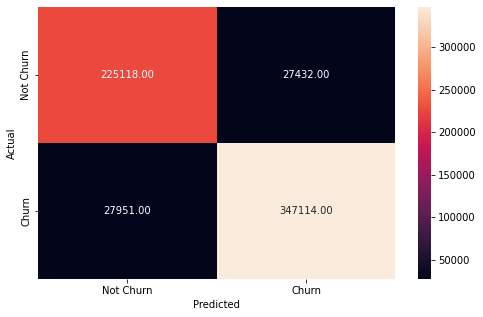

In [159]:
optimal_threshold1=.45
y_pred_train = lg.predict_proba(x_train)
metrics_score(y_train, y_pred_train[:,1]>optimal_threshold1)

### Linear Determinant Analysis (LDA) Model

In [160]:
#fitting lda model
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.88      0.89      0.89    252550
           1       0.93      0.92      0.92    375065

    accuracy                           0.91    627615
   macro avg       0.90      0.90      0.90    627615
weighted avg       0.91      0.91      0.91    627615



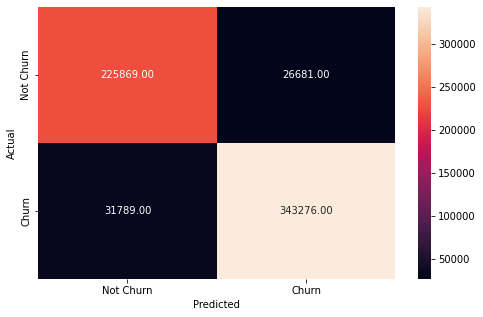

In [161]:
#checking model performance of lda
y_pred_train_lda = lda.predict(x_train)
metrics_score(y_train, y_pred_train_lda)

In [162]:
#creating list of column names
cols=X.columns

#saving coefficients of lda model
coef_lda=lda.coef_

# Create a DataFrame from the coefficients and column names
coef_df = pd.DataFrame({'lda_coefficient': coef_lda.flatten(), 'feature': cols})

# Sort the DataFrame by the 'lda_coefficient' column in descending order
coef_df_sorted = coef_df.sort_values(by='lda_coefficient', ascending=False)


# Set 'feature' as the index and move it to the first column
coef_df_sorted = coef_df_sorted.set_index('feature').reset_index()

# Print the sorted DataFrame
coef_df_sorted

,feature,lda_coefficient
0,plan_Legacy,1.07
1,auto_cancellation_count,0.65
2,billing_interval_Monthly,0.30
3,billing_interval_Semi-Annual,0.25
4,subchannel_Brand,0.21
5,channel_Unpaid,0.15
6,audio_download_count,0.12
7,template_download_count,0.11
8,image_download_count,0.07
9,plan_Enterprise,0.06


In [163]:
coef_df_sorted.to_csv('lda_coef.csv', index=False) 

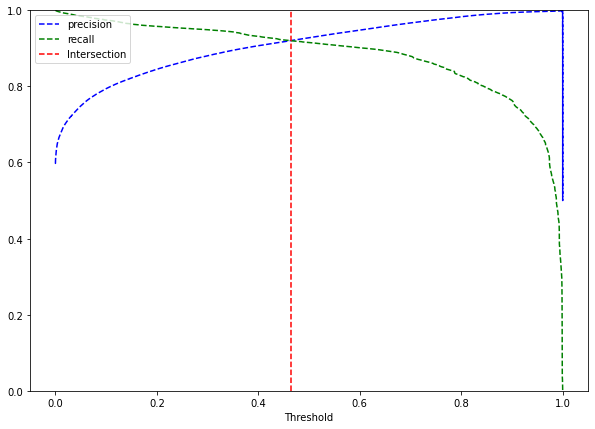

In [164]:
y_scores_lda=lda.predict_proba(x_train) #predict_proba gives the probability of each observation belonging to each class


precisions_lda, recalls_lda, thresholds_lda = precision_recall_curve(y_train, y_scores_lda[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lda, precisions_lda[:-1], 'b--', label='precision')
plt.plot(thresholds_lda, recalls_lda[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])


# Find the threshold value where precision and recall cross
intersection_idx = np.argwhere(np.isclose(precisions_lda[:-1], recalls_lda[:-1], atol=1e-5)).flatten()
if len(intersection_idx) > 0:
    intersection_threshold = thresholds_lda[intersection_idx[0]]
    plt.axvline(intersection_threshold, color='r', linestyle='--', label='Intersection')
    plt.legend(loc='upper left')


plt.show()


In [165]:
# Get the probability scores for class 1 (positive class)
y_scores_class1 = y_scores_lda[:, 1]

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_train, y_scores_class1)

# Print the ROC-AUC score
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9672449738197956
